# Sentiment analysis with hot-one encoding
A basic example of sentiment analysis with sparse encoding, using a dataset from Internet Movie Database (IMDB), using Keras 3 on PyTorch

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Understand the management of **textual data** and **sentiment analysis**

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://keras.io/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result

## Step 1 - Import and init
### 1.1 - Python stuff

In [3]:
import os
from datetime import datetime

project_name = 'K3IMDB1'

# Création d'un identifiant de run basé sur le timestamp pour garantir l'unicité
run_id = f"{project_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Définition des répertoires de travail
run_dir = os.path.join(os.getcwd(), 'runs', run_id)
datasets_dir = os.path.join(run_dir, 'datasets')

# Création des répertoires
os.makedirs(run_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

print(f"Run ID: {run_id}")
print(f"Run Directory: {run_dir}")
print(f"Datasets Directory: {datasets_dir}")

import keras
import keras.datasets.imdb as imdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Run ID: K3IMDB1_20240313_221443
Run Directory: /Users/jules/Documents/Sentiment-analysis/runs/K3IMDB1_20240313_221443
Datasets Directory: /Users/jules/Documents/Sentiment-analysis/runs/K3IMDB1_20240313_221443/datasets


### 1.2 - Parameters
The words in the vocabulary are classified from the most frequent to the rarest.\
`vocab_size` is the number of words we will remember in our vocabulary (the other words will be considered as unknown).\
`hide_most_frequently` is the number of ignored words, among the most common ones\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [4]:
vocab_size           = 5000
hide_most_frequently = 0

epochs               = 10
batch_size           = 512
fit_verbosity        = 1

## Step 2 - Understanding hot-one encoding
#### We have a **sentence** and a **dictionary** :

In [6]:
sentence = "I've never seen a movie like this before"

dictionary  = {"a":0, "before":1, "fantastic":2, "i've":3, "is":4, "like":5, "movie":6, "never":7, "seen":8, "this":9}

#### We encode our sentence as a **numerical vector** :

In [7]:
sentence_words = sentence.lower().split()

sentence_vect  = [ dictionary[w] for w in sentence_words ]

print('Words sentence are         : ', sentence_words)
print('Our vectorized sentence is : ', sentence_vect)

Words sentence are         :  ["i've", 'never', 'seen', 'a', 'movie', 'like', 'this', 'before']
Our vectorized sentence is :  [3, 7, 8, 0, 6, 5, 9, 1]


#### Next, we **one-hot** encode our vectorized sentence as a tensor :

In [8]:
# ---- We get a (sentence length x vector size) matrix of zeros
#
onehot = np.zeros( (10,8) )

# ---- We set some 1 for each word
#
for i,w in enumerate(sentence_vect):
    onehot[w,i]=1

# --- Show it
#
print('In a basic way :\n\n', onehot, '\n\nWith a pandas wiew :\n')
data={ f'{sentence_words[i]:.^10}':onehot[:,i] for i,w in enumerate(sentence_vect) }
df=pd.DataFrame(data)
df.index=dictionary.keys()
# --- Pandas Warning 
# 
df.style.format('{:1.0f}').highlight_max(axis=0).set_properties(**{'text-align': 'center'})

In a basic way :

 [[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]] 

With a pandas wiew :



,...i've...,..never...,...seen...,....a.....,..movie...,...like...,...this...,..before..
a,0,0,0,1,0,0,0,0
before,0,0,0,0,0,0,0,1
fantastic,0,0,0,0,0,0,0,0
i've,1,0,0,0,0,0,0,0
is,0,0,0,0,0,0,0,0
like,0,0,0,0,0,1,0,0
movie,0,0,0,0,1,0,0,0
never,0,1,0,0,0,0,0,0
seen,0,0,1,0,0,0,0,0
this,0,0,0,0,0,0,1,0


## Step 3 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://keras.io/api/datasets/imdb/)  
Note : Due to their nature, textual data can be somewhat complex.

### 3.1 - Data structure :  
The dataset is composed of 2 parts: 

 - **reviews**, this will be our **x**
 - **opinions** (positive/negative), this will be our **y**

There are also a **dictionary**, because words are indexed in reviews

```
<dataset> = (<reviews>, <opinions>)

with :  <reviews>  = [ <review1>, <review2>, ... ]
        <opinions> = [ <rate1>,   <rate2>,   ... ]   where <ratei>   = integer

where : <reviewi> = [ <w1>, <w2>, ...]    <wi> are the index (int) of the word in the dictionary
        <ratei>   = int                   0 for negative opinion, 1 for positive


<dictionary> = [ <word1>:<w1>, <word2>:<w2>, ... ]

with :  <wordi>   = word
        <wi>      = int

```

### 3.2 - Load dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://keras.io/api/datasets/imdb)  
However, Keras offers some useful tools for formatting textual data - See [documentation](hhttps://keras.io/api/layers/preprocessing_layers/text/text_vectorization/)  

By default : 
 - Start of a sequence will be marked with : 1
 - Out of vocabulary word will be : 2
 - First index will be : 3

In [9]:
# ----- Retrieve x,y
#
start_char = 1      # Start of a sequence (padding is 0)
oov_char   = 2      # Out-of-vocabulary
index_from = 3      # First word id

(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size, 
                                                       skip_top   = hide_most_frequently,
                                                       start_char = start_char, 
                                                       oov_char   = oov_char, 
                                                       index_from = index_from)

def rmax(seq):
    """Calcule le maximum récursif dans une liste de listes."""
    return max(max(subseq) if isinstance(subseq, list) else subseq for subseq in seq)

def rmin(seq):
    """Calcule le minimum récursif dans une liste de listes."""
    return min(min(subseq) if isinstance(subseq, list) else subseq for subseq in seq)

print("Max(x_train,x_test)  : ", rmax(x_train + x_test))
print("Min(x_train,x_test)  : ", rmin(x_train + x_test))
print("Len(x_train)         : ", len(x_train))
print("Len(x_test)          : ", len(x_test))


17464789/17464789 [==============================] - 1s 0us/step
Max(x_train,x_test)  :  4999
Min(x_train,x_test)  :  1
Len(x_train)         :  25000
Len(x_test)          :  25000


## Step 4 - About our dataset
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

### 4.1 - Sentences encoding

In [10]:
print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nOpinions (y_train) :\n\n',y_train)


Review example (x_train[12]) :

 [1, 13, 119, 954, 189, 1554, 13, 92, 459, 48, 4, 116, 9, 1492, 2291, 42, 726, 4, 1939, 168, 2031, 13, 423, 14, 20, 549, 18, 4, 2, 547, 32, 4, 96, 39, 4, 454, 7, 4, 22, 8, 4, 55, 130, 168, 13, 92, 359, 6, 158, 1511, 2, 42, 6, 1913, 19, 194, 4455, 4121, 6, 114, 8, 72, 21, 465, 2, 304, 4, 51, 9, 14, 20, 44, 155, 8, 6, 226, 162, 616, 651, 51, 9, 14, 20, 44, 10, 10, 14, 218, 4843, 629, 42, 3017, 21, 48, 25, 28, 35, 534, 5, 6, 320, 8, 516, 5, 42, 25, 181, 8, 130, 56, 547, 3571, 5, 1471, 851, 14, 2286]

Opinions (y_train) :

 [1 0 0 ... 0 1 0]


### 4.2 - Load dictionary

In [12]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from <index_from>
#
word_index = {w:(i+index_from) for w,i in word_index.items()}

# ---- Add <pad>, <start> and <unknown> tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- About dictionary
#
print('\nDictionary size     : ', len(word_index))
print('\nSmall extract :\n')
for k in range(440,455):print(f'    {k:2d} : {index_word[k]}' )

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

1641221/1641221 [==============================] - 0s 0us/step

Dictionary size     :  88588

Small extract :

    440 : hope
    441 : entertaining
    442 : she's
    443 : mr
    444 : overall
    445 : evil
    446 : called
    447 : loved
    448 : based
    449 : oh
    450 : several
    451 : fans
    452 : mother
    453 : drama
    454 : beginning


### 4.3 - Have a look, for human

In [14]:
def print_subtitle(title):
    print(f"\n{'=' * len(title)}\n{title}\n{'=' * len(title)}")

In [15]:
# Chargement du dictionnaire de mots d'IMDB
word_index = imdb.get_word_index()

# Ajout de 3 parce que Keras réserve 'padding', 'start of sequence' et 'unknown'
word_index = {k: (v + index_from) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def dataset2text(sequence):
    return ' '.join([reverse_word_index.get(i, '?') for i in sequence])

In [16]:
print_subtitle('Review example :')
print(x_train[12])

print_subtitle('After translation :')
print(dataset2text(x_train[12]))


Review example :
[1, 13, 119, 954, 189, 1554, 13, 92, 459, 48, 4, 116, 9, 1492, 2291, 42, 726, 4, 1939, 168, 2031, 13, 423, 14, 20, 549, 18, 4, 2, 547, 32, 4, 96, 39, 4, 454, 7, 4, 22, 8, 4, 55, 130, 168, 13, 92, 359, 6, 158, 1511, 2, 42, 6, 1913, 19, 194, 4455, 4121, 6, 114, 8, 72, 21, 465, 2, 304, 4, 51, 9, 14, 20, 44, 155, 8, 6, 226, 162, 616, 651, 51, 9, 14, 20, 44, 10, 10, 14, 218, 4843, 629, 42, 3017, 21, 48, 25, 28, 35, 534, 5, 6, 320, 8, 516, 5, 42, 25, 181, 8, 130, 56, 547, 3571, 5, 1471, 851, 14, 2286]

After translation :
<START> i love cheesy horror flicks i don't care if the acting is sub par or whether the monsters look corny i liked this movie except for the <UNK> feeling all the way from the beginning of the film to the very end look i don't need a 10 page <UNK> or a sign with big letters explaining a plot to me but dark <UNK> takes the what is this movie about thing to a whole new annoying level what is this movie about br br this isn't exceptionally scary or thrillin

### 4.4 - Few statistics

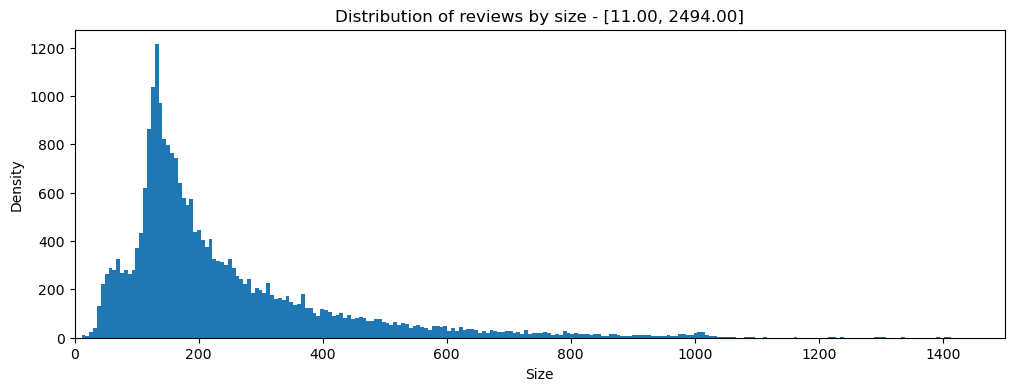

In [17]:
# Calcul des tailles des avis
sizes = [len(i) for i in x_train]

# Création de l'histogramme
plt.figure(figsize=(12,4))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,1500])

# Sauvegarde de la figure
plt.savefig('img/01-stats-sizes.png', dpi=300)  # Spécifiez le chemin et le format souhaité

# Affichage de l'histogramme
plt.show()


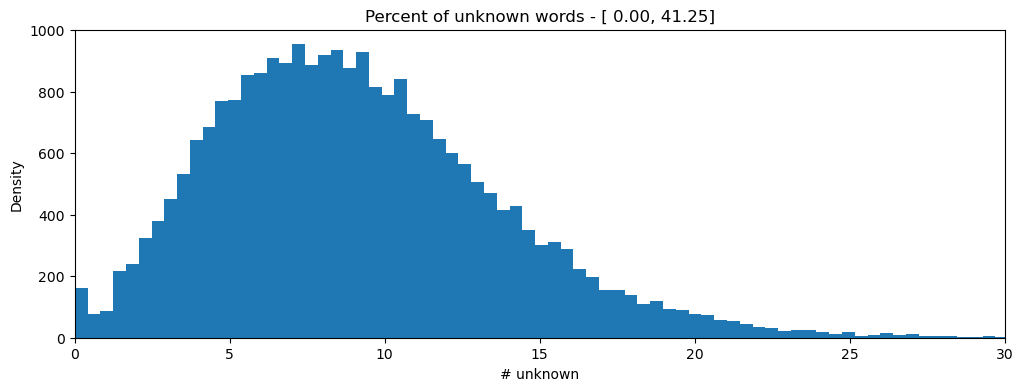

In [18]:
unk=[ 100*(s.count(oov_char)/len(s)) for s in x_train]
plt.figure(figsize=(12,4))
plt.hist(unk, bins=100)
plt.gca().set(title='Percent of unknown words - [{:5.2f}, {:5.2f}]'.format(min(unk),max(unk)), 
              xlabel='# unknown', ylabel='Density', xlim=[0,30])
plt.savefig('img/02-stats-unknown.png', dpi=300) 
plt.show()

## Step 5 - Basic approach with "one-hot" vector encoding
Basic approach.  

Each sentence is encoded with a **vector** of length equal to the **size of the dictionary**.   

Each sentence will therefore be encoded with a simple vector.  
The value of each component is 0 if the word is not present in the sentence or 1 if the word is present.

For a sentence s=[3,4,7] and a dictionary of 10 words...    
We wil have a vector v=[0,0,0,1,1,0,0,1,0,0,0]



### 5.1 - Our one-hot encoder function

In [19]:
def one_hot_encoder(x, vector_size=10000):

    # ---- Set all to 0
    #
    x_encoded = np.zeros((len(x), vector_size))
    
    # ---- For each sentence
    #
    for i,sentence in enumerate(x):
        for word in sentence:
            x_encoded[i, word] = 1.

    return x_encoded

### 5.2 - Encoding..

In [20]:
x_train = one_hot_encoder(x_train, vector_size=vocab_size)
x_test  = one_hot_encoder(x_test,  vector_size=vocab_size)

print("To have a look, x_train[12] became :", x_train[12] )

To have a look, x_train[12] became : [0. 1. 1. ... 0. 0. 0.]


## Step 6 - Build a nice model

In [21]:
model = keras.Sequential(name='My IMDB classifier')

model.add(keras.layers.Input( shape=(vocab_size,) ))
model.add(keras.layers.Dense( 32, activation='relu'))
model.add(keras.layers.Dense( 32, activation='relu'))
model.add(keras.layers.Dense( 1,  activation='sigmoid'))
    
model.compile(optimizer = 'rmsprop',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])

model.summary()

Model: "My IMDB classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160032    
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 161121 (629.38 KB)
Trainable params: 161121 (629.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
